## HW2 Solution

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# load packages
from __future__ import division, print_function
import glob
import os
import cv2
import PIL
import random
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from scipy.optimize import linear_sum_assignment

### Get features.pth
***

In [4]:
# parameters setting
query_path = "image_retrieval/query/"
image_path = "image_retrieval/images/"
query_num = 34     # total query image number
image_num = 136    # total retrieval image number
kps_num = 20       # key points number on one image
patch_size = 32    # patch size
patches = torch.zeros(query_num+image_num, kps_num,1, 32, 32)
keypoints = torch.zeros(query_num+image_num, kps_num, 2)

In [5]:
# Initiate SURF detector
sift = cv2.xfeatures2d.SIFT_create(600)

In [6]:
def getPatches(kps, img, size=32, num=500):
    res = torch.zeros(num, 1, size, size)
    if type(img) is np.ndarray:
        img = torch.from_numpy(img)
    h, w = img.shape      # note: for image, the x direction is the verticle, y-direction is the horizontal...
    for i in range(num):
        cx, cy = kps[i]
        cx, cy = int(cx), int(cy)
        dd = int(size/2)
        xmin, xmax = max(0, cx - dd), min(w, cx + dd ) 
        ymin, ymax = max(0, cy - dd), min(h, cy + dd ) 
        
        xmin_res, xmax_res = dd - min(dd,cx), dd + min(dd, w - cx)
        ymin_res, ymax_res = dd - min(dd,cy), dd + min(dd, h - cy)
        res[i, 0, ymin_res: ymax_res, xmin_res: xmax_res] = img[ymin: ymax, xmin: xmax]
    return res

In [7]:
# tensor for query/image patches
for idx in range(query_num+image_num):
    if idx < query_num:
        img_dir = os.path.join(query_path,"q{}.JPG".format(idx+1))
    else:
        img_dir = os.path.join(image_path,"{}.JPG".format(idx+1-query_num))
    image = cv2.imread(img_dir)
    img= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    ## find the keypoints and descriptors with SIFT
    kps, des = sift.detectAndCompute(img, None)
    
    ## sort by response, and remove duplicate
    kps.sort(key=lambda x:x.response, reverse=True)
    temp = set()
    kps2 = [x for x in kps if x.pt not in temp and not temp.add(x.pt)]
        
    if len(kps2) < 20:
        print("Cannot find 20 keypoints on image {}".format(img_dir))
        break
    
    keypoints_img = [kps2[a].pt for a in range(kps_num)] 
    keypoints[idx]= torch.Tensor(keypoints_img).int()
    patches[idx] = getPatches(keypoints_img, img, size=patch_size, num=kps_num)    

In [8]:
# import network, , load pretrained weights, and turn on testing mode
from descriptor import DesNet
model = DesNet()
model.cuda()
model.eval()
trained_weights = torch.load("checkpoint.pth")
model.load_state_dict(trained_weights["state_dict"])

<All keys matched successfully>

In [9]:
print(patches.shape)

torch.Size([170, 20, 1, 32, 32])


In [10]:
# get descriptions
with torch.no_grad():
    features = model(patches.view(-1,1,32, 32).cuda()).view(-1,20,128)
torch.save(features, "features.pth")

### Get similarity matrices
***

In [56]:
def getCost_one2one(des1, des2, kps_num=20):
    des1 = des1.view(kps_num, 1, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    des2 = des2.view(1, kps_num, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    
    simi = (1 + F.cosine_similarity(des1, des2))/2
    simi = simi.view(kps_num, kps_num)
    cost = 1 - simi
    row_ind, col_ind = linear_sum_assignment(cost.cpu().numpy())
    
    return simi[row_ind, col_ind].sum()

def getCost_many2many(des1, des2, kps_num=20, threshold=0.068):
    des1 = des1.view(kps_num, 1, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    des2 = des2.view(1, kps_num, 128).expand(kps_num, kps_num, 128).contiguous().view(kps_num*kps_num, 128)
    
    simi = (1 + F.cosine_similarity(des1, des2))/2
    simi = simi.view(kps_num, kps_num)
    simiNorm = torch.sqrt(torch.sum(simi * simi))
    simi_w = simi / simiNorm
#     threshold = max(threshold, (simi_w.max() - simi_w.min())*0.01 + simi_w.min())
    simi_w = simi_w.gt(threshold).float()
    
    return (simi*simi_w).sum()

In [57]:
# You can speed upt if you use tensor manipulations instead of two loops
similarity_one2one = torch.zeros(query_num, image_num)
similarity_many2many = torch.zeros(query_num, image_num)
for idx in range(query_num):
    print("finished No.{} query".format(idx+1))
    for jdx in range(image_num):
        similarity_one2one[idx,jdx] = getCost_one2one(features[idx], features[jdx+query_num])
        similarity_many2many[idx, jdx] = getCost_many2many(features[idx], features[jdx+query_num])

finished No.1 query
finished No.2 query
finished No.3 query
finished No.4 query
finished No.5 query
finished No.6 query
finished No.7 query
finished No.8 query
finished No.9 query
finished No.10 query
finished No.11 query
finished No.12 query
finished No.13 query
finished No.14 query
finished No.15 query
finished No.16 query
finished No.17 query
finished No.18 query
finished No.19 query
finished No.20 query
finished No.21 query
finished No.22 query
finished No.23 query
finished No.24 query
finished No.25 query
finished No.26 query
finished No.27 query
finished No.28 query
finished No.29 query
finished No.30 query
finished No.31 query
finished No.32 query
finished No.33 query
finished No.34 query


In [58]:
# save similarity matrices
similarity_one2one_dir = "similarity_one2one.pt"
similarity_many2many_dir = "similarity_many2many.pt"
torch.save(similarity_one2one, similarity_one2one_dir)
torch.save(similarity_many2many, similarity_many2many_dir)

### Get retrieval.pth
***

In [59]:
topk_one2one_ind   = torch.zeros(4, 34, 4)  # k, 34, k
topk_many2many_ind = torch.zeros(4, 34, 4)  # k, 34, k

for k in range(4):
    _, topk_one2one   = torch.topk(similarity_one2one, k+1, dim = 1,sorted=True)
    _, topk_many2many = torch.topk(similarity_many2many, k+1, dim = 1,sorted=True)
    
    topk_one2one_ind[k, :, :k+1] = topk_one2one + 1
    topk_many2many_ind[k, :, :k+1] = topk_many2many + 1

In [60]:
# read gt
gt_dir = "image_retrieval/ground_truth.txt"
gt = torch.empty(34, 4)
with open(gt_dir, 'r') as f:
    point = 0
    for line in f:
        if not line.startswith("q"):
            continue
        one_line = line.strip().split("  ")
        query_idx = int(one_line[0][1:])
        image_idx = int(one_line[1])
        gt[query_idx-1][point%4] = image_idx
        point+=1

In [61]:
torch.save([topk_many2many_ind[3], topk_one2one_ind[3]], "retrieval.pth")

### Draw plots
***

In [62]:
# read gt
gt_dir = "image_retrieval/ground_truth.txt"
gt = torch.empty(34, 4)
with open(gt_dir, 'r') as f:
    point = 0
    for line in f:
        if not line.startswith("q"):
            continue
        one_line = line.strip().split("  ")
        query_idx = int(one_line[0][1:])
        image_idx = int(one_line[1])
        gt[query_idx-1][point%4] = image_idx
        point+=1

In [63]:
# precision and recall
P_one2one = torch.zeros(4,1)
R_one2one = torch.zeros(4,1)
for k in range(4):
    P_1, R_1 = 0, 0
    for idx in range(34):
        for topk_idx in topk_one2one_ind[k][idx][:k+1]:
            if int(topk_idx) in gt[idx]:
                P_1 += 1/(k+1)/34 # sum_P /Q
                R_1 += 1/4/34
    P_one2one[k] = P_1
    R_one2one[k] = R_1
    
P_many2many = torch.zeros(4,1)
R_many2many = torch.zeros(4,1)
for k in range(4):
    P_1, R_1 = 0, 0
    for idx in range(34):
        for topk_idx in topk_many2many_ind[k][idx][:k+1]:
            if int(topk_idx) in gt[idx]:
                P_1 += 1/(k+1)/34 # sum_P /Q
                R_1 += 1/4/34
    P_many2many[k] = P_1
    R_many2many[k] = R_1
    
print(P_one2one[:,0])
print(R_one2one[:,0])
print(P_many2many[:,0])
print(R_many2many[:,0])

tensor([1.0000, 0.8971, 0.8039, 0.7353])
tensor([0.2500, 0.4485, 0.6029, 0.7353])
tensor([0.9118, 0.7794, 0.6667, 0.5294])
tensor([0.2279, 0.3897, 0.5000, 0.5294])


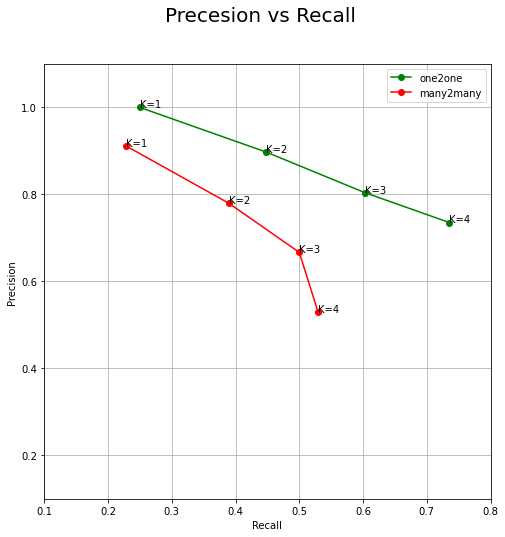

In [64]:
k = [i for i in range(1, 5)]
fig = plt.figure(figsize=(8, 8))
plt.suptitle('Precesion vs Recall', fontsize=20)
ax1 = fig.add_subplot(111)
ax1.set_xlim(0.1,0.8)
ax1.set_ylim(0.1,1.1)
ax1.set_ylabel('Precision')
ax1.set_xlabel('Recall')
ax1.grid(True)
lns1 = ax1.plot(R_one2one[:,0].numpy(), P_one2one[:,0].numpy(), "-go",label="one2one")
for i in range(4):
    ax1.annotate('K={}'.format(i+1), xy=(R_one2one[i,0].numpy(), P_one2one[i,0].numpy()), textcoords='data')
    ax1.annotate('K={}'.format(i+1), xy=(R_many2many[i,0].numpy(), P_many2many[i,0].numpy()), textcoords='data')
lns2 = ax1.plot(R_many2many[:,0].numpy(), P_many2many[:,0].numpy(), "-ro",label="many2many")
lnss = lns1+lns2
labss = [h.get_label() for h in lnss]
ax1.legend(lnss, labss, loc=0)